<a href="https://colab.research.google.com/github/CamelGoong/NLP/blob/main/Text_Summarization_with_Attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 어텐션을 이용한 텍스트요약

1) 추출적 요약: 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법입니다. 그렇기 때문에 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들입니다.

2)추상적 요약: 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법입니다. 마치 사람이 요약하는 것 같은 방식인데, 당연히 추출적 요약보다는 난이도가 높습니다. 이 방법은 주로 인공 신경망을 사용하며 대표적인 모델로 seq2seq가 있습니다. 이 방법의 단점이라면 seq2seq와 같은 인공 신경망들은 기본적으로 지도 학습이라는 점입니다. 다시 말해 추상적 요약을 인공 신경망으로 훈련하기 위해서는 '원문' 뿐만 아니라 '실제 요약문'이라는 레이블 데이터가 있어야 합니다. 그렇기 때문에 데이터를 구성하는 것 자체가 하나의 부담

# <추상적 요약>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import keras
import numpy as np
#!pip install numpy==1.19.3
#!pip install keras==2.3.1
#!pip install tensorflow==2.0.0

Using TensorFlow backend.


In [ ]:
print(np.version.version)
print(keras.__version__)
print(tf.__version__)

1.19.3
2.3.1
2.0.0


In [ ]:
# 필요한 library import
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords # 불용어 사전 imoport
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

np.random.seed(seed = 0)

# 1) 데이터 로드하기

In [ ]:
!unzip -qq "/content/drive/MyDrive/NLP/Text_Summarization/archive.zip"

In [ ]:
# Reviews.csv 파일을 데이터프레임으로 불러오기 / 단, 10만개만.
data = pd.read_csv('/content/Reviews.csv', nrows = 100000)
print('리뷰 전체 갯수:', len(data))

리뷰 전체 갯수: 100000


In [ ]:
data.head()
# 이중에서 필요한 열은 Summary와 Text열

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# 필요한 열만 추출해서 다시 저장
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [ ]:
# 랜덤으로 샘플 10개 추출
data.sample(10)

,Text,Summary
3582,"I rarely eat anything but whole wheat pasta, b...",reminds me of Italy
60498,I absolutely love 5-hour ENERGY! I use it afte...,5-hour ENERGY Highly Recommend!
53227,"this chocolate is a true treat to eat, perfect...",supreme chocolate
21333,Greenies are very muched loved as a tatsy Trea...,Excellent Teeth Cleaner
3885,I love these noodles. They are really great f...,Great and good price!
51521,These are great! As a lover of all chips I'm s...,"Delicious, just like Salt and Vinegar Chips!"
84261,Like other customers I divide these into handf...,"Great snack, great value"
10685,I recommend this instead for the same price: <...,"It's ok, but certainly not worth the cost"
59948,"The noodles were all very broken, but the tast...",Knorr's beef noodles
41032,"Despite claiming they use the ""finest ingredie...",HORRIBLE INGREDIENTS


#2) 데이터 정제하기

중복 데이터 및 null 데이터 제거

In [ ]:
# 데이터에 중복 데이터가 있는지 확인.
print("Text 열에서 중복을 배제한 유일한 샘플의 수: ", data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수: ', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수:  88426
Summary 열에서 중복을 배제한 유일한 샘플의 수:  72348


In [ ]:
# Text 열에서 중복된 데이터 제거
data.drop_duplicates(subset = ['Text'], inplace = True)
print("전체 샘플 수: ", len(data))

전체 샘플 수:  88426


In [ ]:
# data의 null값 확인
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [ ]:
# data의 null값 제거
data.dropna(axis = 0, inplace = True)
print("전체 샘플 수: ", len(data))

전체 샘플 수:  88425


샘플 내부를 전처리

In [ ]:
# 동일한 의미를 가졌지만, 스펠링이 다른 단어들을 정규화하기 위한 사전 생성
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [ ]:
# NLTK의 불용어
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # set은 데이터의 중복을 삭제해줌.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print('불용어 개수: ', len(stop_words))
print(stop_words)

불용어 개수:  179
{'to', 'further', 'him', 'down', 'hasn', "couldn't", 'as', 'ours', 'who', 'being', 'yours', 'this', 'then', 'aren', "wouldn't", 'didn', 'did', 'of', 'own', 'no', 'below', 'and', 'from', 'same', "hasn't", 'with', 'under', 'wouldn', 'won', 'there', 'up', 'such', 'does', 's', 'where', 'them', 'hadn', 'above', 'until', 'ma', "needn't", "you'll", 'not', 'himself', 'mustn', 're', 'each', 'by', "she's", 'hers', 'should', 've', 'doesn', 'having', 'have', 'you', 'your', "that'll", 'if', 'while', 'm', 'will', 'a', 'couldn', 'here', 'y', 'weren', 'our', "mustn't", 'all', 'few', "won't", 'these', 'both', 'we', 'out', "you've", "isn't", 'yourself', 'only', 'ourselves', 'theirs', 'me', 'so', 'what', 'during', 'about', "aren't", 'yourselves', 'between', 'against', "should've", "shouldn't", 'nor', 'my', "don't", 'll', 'now', 'over', "mightn't", 'her', 'on', 'haven', 'she', 'after', 't', 'how', 'very', 'wasn', "you're", "weren't", "didn't", 'at', 'can', 'other', 'is', 'don', "haven't", 'it

In [ ]:
# 전처리 함수 설계: Text 열에서는 불용어를 제거, Summary 열에서는 불용어를 제거X
def preprocess_sentence(sentence, remove_stopwords = True):
  sentence = sentence.lower() # 텍스트 소문자화
  sentence = BeautifulSoup(sentence, 'lxml').text # html 태그 제거
  sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
  sentence = re.sub('"', "", sentence) # 쌍따옴표 제거
  sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
  sentence = re.sub(r"'s\b", "", sentence) # 소유격 제거
  sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자 공백으로 변환
  sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경 EX) ummmmmmmm yeah -> umm yeah

  # 불용어 제거 (Text)
  if remove_stopwords:
    tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)

  # 불용어 미제거 (Summary)
  else:
    tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
  
  return tokens

In [ ]:
# 전처리 함수 Test
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0)) # summary 문장은 두번째 인자를 0으로 줌으로써, 불용어를 제거하지 않도록 함.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [ ]:
# Text 열에 대한 전처리
clean_text = []
for s in data['Text']:
  clean_text.append(preprocess_sentence(s))

clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [ ]:
# Summary 열에 대한 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [ ]:
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [ ]:
# 전처리한 데이터를 다시 데이터프레임에 저장
data['Text'] = clean_text
data['Summary'] = clean_summary

In [ ]:
# 공백인 샘플은 null 값으로 변환
data.replace('', np.nan, inplace = True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [ ]:
data.dropna(axis = 0, inplace = True)
print("전체 샘플수: ", len(data))

전체 샘플수:  88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


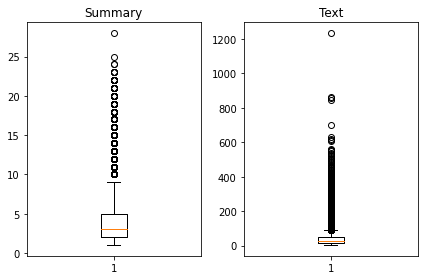

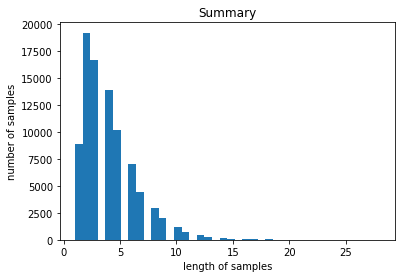

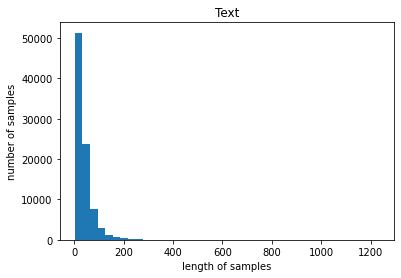

In [ ]:
# 데이터 길이 분포 출력
text_len = [len(s.split()) for s in data ['Text']]
summary_len = [len(s.split()) for s in data ['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title("Text")
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [ ]:
# 패딩의 길이 결정
text_max_len = 50
summary_max_len = 8

In [ ]:
# 위의 문장의 최대 길이보다 큰 샘플들의 개수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
      cnt = cnt + 1

  print('전체 샘플 중 길이가 %s이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))))

In [ ]:
# text 열에 대해서 먼저 확인
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50이하인 샘플의 비율: 0.7745119121724859


In [ ]:
# summary 열에 대해서 확인
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8이하인 샘플의 비율: 0.9424593967517402


In [ ]:
# 정해준 최대 길이보다 큰 샘플들은 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플 수: ', len(data))

전체 샘플 수:  65818


In [ ]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [ ]:
# seq2seq 모델 훈련을 위해서
# 요약 데이터에는 시작 토큰(sostoken)과 종료 토큰(eostoken)을 추가.
data['decoder_input'] = data['Summary'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 저장.
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

# 3) 데이터의 분리

In [ ]:
# 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0]) # 데이터 총 갯수의 인덱스인듯
np.random.shuffle(indices)
print(indices)

[61165 60938 37145 ... 45440 26023  1298]


In [ ]:
# 위의 섞인 정수 시퀀스 순서를 데이터의 샘플 순서로 정의해서 샘플 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
# train / test data 분리
n_of_val = int(len(encoder_input)*0.2) # 전체 input data 중 20%를 테스트 데이터로 사용.
print('테스트 데이터의 수: ', n_of_val)

테스트 데이터의 수:  13163


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 데이터의 개수: ', len(encoder_input_train))
print('훈련 레이블의 개수: ', len(decoder_input_train))
print('테스트 데이터의 개수: ', len(encoder_input_test))
print('테스트 레이블의 개수: ', len(decoder_input_test))

훈련 데이터의 개수:  52655
훈련 레이블의 개수:  52655
테스트 데이터의 개수:  13163
테스트 레이블의 개수:  13163


#4) 정수 인코딩

In [ ]:
# 기계가 텍스트를 숫자로 처리할 수 있도록, 데이터에 대한 정수 인코딩
# 훈련 데이터에 대해서 단어 집합 만들기
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
# 위의 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있음.
# 이 단어 집합 중 빈도수가 낮은 단어들은 배제

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 vaue로 받는다.
for key, value in src_tokenizer.word_counts.items():
  total_freq = total_freq + value
  
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기: ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq/total_freq) * 100)

단어 집합(vocabulary)의 크기:  31987
등장 빈도가 6번 이하인 희귀 단어의 수: 23700
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8287
단어 집합에서 희귀 단어의 비율: 74.09260011879826
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.383968496474902


위의 분석 결과, 등장 빈도가 7회 미만인 저빈도 단어의 단어집합에서의 차지 비중은 74%에 달하나, 등장빈도에서의 차지 비중은 3.39% 밖에되지 않음.
따라서, 6회 이하의 저빈도 단어들을 정수 인코딩에서 배제!!

In [ ]:
src_vocab = 8000 # 단어집합의 크기를 제한
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [ ]:
# 정수 인코딩이 되었는지 확인.
print(encoder_input_train[:3])

[[632, 179, 39, 1, 4640, 1303, 70, 1393, 7, 57, 980, 414, 361, 20, 447, 255, 54, 7683, 1241, 385, 298, 1772, 147, 39, 3, 49, 4388, 108], [4, 489, 206, 446, 91, 583, 100, 2009, 611, 867, 2202, 138, 2766, 334, 2202, 7, 4523, 871, 54, 446, 138, 55, 208, 611, 2009, 2708, 2766, 33, 446, 35, 2766, 2009, 618, 98, 9, 3147, 2767, 75, 100, 4054], [143, 93, 514, 123, 525, 197, 96, 190, 338, 856, 223, 71, 21, 5086, 394, 394, 239, 15, 531, 197]]


In [ ]:
# 레이블에 해당하는 요약 데이터에 대해서도 정수 인코딩 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
# 등장 빈도수가 6회 미만인 단어들이 차지하는 비중 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
  total_freq = total_freq + value

  if value < threshold:
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10524
등장 빈도가 5번 이하인 희귀 단어의 수: 8150
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2374
단어 집합에서 희귀 단어의 비율: 77.44203724819461
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.940836959469056


등장빈도가 5번 이하인 단어들은 단어집합에서 77% 비중을 차지하나, 전체 등장 빈도에서는 5.94% 밖에 되지 않음. 따라서 이 단어들을 정수 인코딩 과정에서 배제

In [ ]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
print(decoder_input_train[:5])

[[1, 130, 15], [1, 15, 19, 240], [1, 51, 63, 385, 319, 118], [1, 397, 948], [1, 29, 122]]


In [ ]:
print(decoder_target_train[:5])

[[130, 15, 2], [15, 19, 240, 2], [51, 63, 385, 319, 118, 2], [397, 948, 2], [29, 122, 2]]


#5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어를 제외해주었기 때문에, 낮은 단어만으로 구성되었던 샘플들은 이제 빈 샘플이 된 것.
상대적으로 길이가 길었던 원문에 비해서 평균 길이가 4 밖에 되지 않았던 요약문의 경우에는 이 현상이 두드러졌을 가능성이 매우 높음.
요약문에서 길이가 0이 된 샘플들의 인텍스를 받아오기. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken, decoder_target에는 eostoken이 추가된 상태이기 때문에 이 두 토큰은 모든 샘플에서 등장하므로, 단어 집합 제한에도 삭제가 되지 않음.
그래서 이제 길이가 0이된 요약문의 실질적인 길이는 1

In [ ]:
# 훈련 데이터와 테스트 데이터에서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [ ]:
print('삭제할 훈련 데이터의 개수:', len(drop_train))
print('삭제할 테스트 데이터의 개수:', len(drop_test))

삭제할 훈련 데이터의 개수: 1310
삭제할 테스트 데이터의 개수: 292


In [ ]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis = 0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis = 0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis = 0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis = 0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis = 0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis = 0)

print("훈련 데이터의 개수: ", len(encoder_input_train))
print('훈련 레이블의 개수: ', len(decoder_input_train))
print('테스트 데이터의 개수: ', len(encoder_input_test))
print('테스트 레이블의 개수: ', len(decoder_input_test))

훈련 데이터의 개수:  51345
훈련 레이블의 개수:  51345
테스트 데이터의 개수:  12871
테스트 레이블의 개수:  12871


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#6) 패딩하기

In [ ]:
# 앞서 계산해둔 최대 길이로 맞추어서 패딩작업을 수행
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding = 'post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding = 'post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding = 'post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding = 'post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding = 'post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding = 'post')

# 7)  seq2seq + attention으로 요약 모델 설계 및 훈련시키기

In [ ]:
# 필요한 라이브러리 import
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

인코더 설계: LSTM 3층으로 쌓기

In [ ]:
# 인코더 설계
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape = (text_max_len,)) # 모두 패딩을 통해서 text_max_len길이로 맞춰놨음.

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

디코더 설계: 단, 출력층은 제외하고 설계. 인코더와 사실상 동일하지만, 초기 상태(initial_state)를 인코더의 상태로 주어야 함.

In [ ]:
# 디코더
decoder_inputs = Input(shape = (None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) # 초기상태를 인코더의 상태로 위에서 그대로 가져온 것.

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

지금까지 위에서 설계했던 모델은 seq2seq 챕터에서 배웠던 내용과 동일.
그러나, 이번에는 **어텐션 매커니즘**을 사용할 에정이므로, 방금 위에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계할 예정. (github에서 공개된 attention함수를 import해서 사용할 예정.)

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
# 모델 컴파일
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

In [ ]:
# 조기 종료 조건을 설정. 모델 학습
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 256, callbacks = [es], epochs = 5)

Train on 51345 samples, validate on 12871 samples
Epoch 1/5
51345/51345 [==============================] - 1038s 20ms/sample - loss: 2.3535 - val_loss: 2.2743
Epoch 2/5
51345/51345 [==============================] - 1039s 20ms/sample - loss: 2.2748 - val_loss: 2.1995
Epoch 3/5
51345/51345 [==============================] - 1046s 20ms/sample - loss: 2.1934 - val_loss: 2.1223
Epoch 4/5
51345/51345 [==============================] - 1048s 20ms/sample - loss: 2.1141 - val_loss: 2.0639
Epoch 5/5
51345/51345 [==============================] - 1040s 20ms/sample - loss: 2.0502 - val_loss: 2.0212


# 8) seq2seq + attention으로 요약 모델 테스트하기

In [ ]:
# 테스트를 위한 3개의 사전 만들기
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음.
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음.
tar_index_to_word = tar_tokenizer.index_word # 오약 단어 집합에서 정수 -> 단어를 얻음.

seq2seq은 훈련 단계와 테스트 단계의 동작이 다르므로, 테스트 단계의 모델을 별도로 다시 설계.

In [ ]:
# 인코터 설계
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

In [ ]:
# 테스트 단계의 디코더를 설계
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape = (hidden_size,))
decoder_state_input_c = Input(shape = (hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

In [ ]:
decoder_hidden_state_input = Input(shape = (text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [ ]:
# 테스트를 위해 사용되는 함수 decode_sequence를 설계
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 토큰 생성
  target_seq = np.zeros((1,1))
  target_seq[0,0] = tar_word_to_index['sostoken']
  
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition: # stop_condition이 True가 될 때까지 반복.
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = tar_index_to_word[sampled_token_index]

    if (sampled_token != 'eostoken'):
      decoded_sentence += ' ' + sampled_token

    # <eos>에 도달하거나 최대 길이를 넘으면 중단.
    if(sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len-1)):
      stop_condition = True

    # 길이가 1인 타겟 시퀀스를 업데이트
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index

    # 상태를 업데이트
    e_h, e_c = h, c

  return decoded_sentence

테스트 단계에서 원문과 실제 요약문, 예측 요약문을 비교하기 위한 정수 시퀀스를 텍스트 시퀀스로 만드는 함수를 설계

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
  sentence = ''
  for i in input_seq:
    if(i!=0):
      sentence = sentence + src_index_to_word[i] + ' '
  return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
  sentence = ''
  for i in input_seq:
    if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
      sentence = sentence + tar_index_to_word[i] + ' '
  return sentence

In [ ]:
# 테스트 샘플 중 500번부터 1000번까지 테스트
for i in range(100, 200):
  print("원문: ", seq2text(encoder_input_test[i]))
  print('실제 요약문: ', seq2summary(decoder_input_test[i]))
  print('예측 요약문: ', decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

원문:  year old westie used product years truly one best worry getting soap dogs eyes 
실제 요약문:  great 
예측 요약문:   great product
원문:  bought toy year ago golden girl would wolf food forget eaten saw store hesitant would get tries showing food came mastered hungry bring place feet takes lot longer eat content happy since bought round version mastered tug jug 
실제 요약문:  golden loves it 
예측 요약문:   great product
원문:  tea award usa know mandarin silk loose leaf oolong tea like name suggests silk silk tongue tea warm relaxing taste makes feel wonderful well done art tea 
실제 요약문:  awesome 
예측 요약문:   great tea
원문:  colors intense quite normal hoping strong colors let tested 
실제 요약문:  its okay 
예측 요약문:   great coffee
원문:  best junk food items taste craving chips without guilt kids love lunches 
실제 요약문:  awesome 
예측 요약문:   great product
원문:  yes dog loves loves death gumball machine broken back using kong discover buy another plastic part gumball machine want reward cheap supplier 
실제 요약문:  key are c